Imports

In [162]:
from catheter_utils import geometry

import glob
import os
import math
import textwrap

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

%matplotlib inline

Constants and Paths

In [163]:
# Main data paths for each catheter (manually input)
main_paths = ['/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter231/', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter299/', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter306/']

# Ground truth paths (to manually input)
GT_filename_home = ['/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter231/gt/home/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter299/gt/home/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter306/gt/home/GroundTruthCoords.csv']
GT_filename_pos15 = ['/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter231/gt/p15/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter299/gt/p15/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter306/gt/p15/GroundTruthCoords.csv']
GT_filename_neg15 = ['/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter231/gt/n15/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter299/gt/n15/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter306/gt/n15/GroundTruthCoords.csv']
GT_filename_pos5 = ['/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter231/gt/p5/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter299/gt/p5/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter306/gt/p5/GroundTruthCoords.csv']
GT_filename_neg5 = ['/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter231/gt/n5/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter299/gt/n5/GroundTruthCoords.csv', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Data/catheter306/gt/n5/GroundTruthCoords.csv']

# Where you would like to save the comparison plots (manually input)
comparison_plot_paths = ['/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Figures/comparisonPlots/catheter231/', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Figures/comparisonPlots/catheter299/', '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Figures/comparisonPlots/catheter306/']

# Where you would like to save the box plots (manually input)
box_plot_path = '/Users/arjungupta/Desktop/MR Tracking Tests/Dynamic Tracking/Figures/boxPlots/'

sequences = ['Hadamard Multiplexed', 'Conventional']
algorithm = 'jpng'

# Recordings for each motion profile
recordings = [ [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'},
                
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ],
                
               [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'}, 
                 
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ],
                
               [ {'{}'.format(sequences[0]): '0001',
                  '{}'.format(sequences[1]): '0001'},
                
                 {'{}'.format(sequences[0]): '0002',
                  '{}'.format(sequences[1]): '0002'} ] ]
                 
# Function for getting ground truth coords in dataframe format
def get_gt_coords(path):

    gt_file = open(path, 'r')
    reader = gt_file.readlines()
    distal_gt = []
    proximal_gt = []

    for line in reader[1:]:
        data = line.split(',')
        if (data[-2].strip() == 'dist'):
            distal_index = int(data[-1].strip())
            distal_gt = np.array([float(data[1]), float(data[2]), float(data[3])])
            distal_df = pd.DataFrame({'Coil': distal_index, 'X Coord': distal_gt[0], 'Y Coord': distal_gt[1], 'Z Coord': distal_gt[2]}, index=[0])
            
        elif (data[-2].strip() == 'prox'):
            proximal_index = int(data[-1].strip())
            proximal_gt = np.array([float(data[1]), float(data[2]), float(data[3])])
            proximal_df = pd.DataFrame({'Coil': proximal_index, 'X Coord': proximal_gt[0], 'Y Coord': proximal_gt[1], 'Z Coord': proximal_gt[2]}, index=[0])
    
    gt_df = pd.concat([distal_df, proximal_df])
    
    return gt_df

# Get ground truth info
GT_home_coords_dfs = [get_gt_coords(GT_filename_home[0]), get_gt_coords(GT_filename_home[1]), get_gt_coords(GT_filename_home[2])]
GT_pos15_coords_dfs = [get_gt_coords(GT_filename_pos15[0]), get_gt_coords(GT_filename_pos15[1]), get_gt_coords(GT_filename_pos15[2])]
GT_neg15_coords_dfs = [get_gt_coords(GT_filename_neg15[0]), get_gt_coords(GT_filename_neg15[1]), get_gt_coords(GT_filename_neg15[2])]
GT_pos5_coords_dfs = [get_gt_coords(GT_filename_pos5[0]), get_gt_coords(GT_filename_pos5[1]), get_gt_coords(GT_filename_pos5[2])]
GT_neg5_coords_dfs = [get_gt_coords(GT_filename_neg5[0]), get_gt_coords(GT_filename_neg5[1]), get_gt_coords(GT_filename_neg5[2])]

Constant Numerical Values

In [164]:
num_caths = 3
num_profs = 4

# Coil numbers
distal_index = 6
proximal_index = 7

# Amplitudes and periods
amplitude_resp = 15 # mm
period_resp = 4024 # ms

amplitude_card = 5 # mm
period_card = 1006 # ms

# Device geometry index
geometry_index = 1 # 1 for catheter, 2 for dilator

# Start indices for each motion profile

start_idx = [ [ {'{}'.format(sequences[0]): 98,
                 '{}'.format(sequences[1]): 43}, 
                        
                {'{}'.format(sequences[0]): 63,
                 '{}'.format(sequences[1]): 48} ], 

              [ {'{}'.format(sequences[0]): 88,
                 '{}'.format(sequences[1]): 52}, 
                        
                {'{}'.format(sequences[0]): 81,
                 '{}'.format(sequences[1]): 45} ], 

              [ {'{}'.format(sequences[0]): 62,
                 '{}'.format(sequences[1]): 35}, 
                        
                {'{}'.format(sequences[0]): 60,
                 '{}'.format(sequences[1]): 31} ] ]

# Function for calculating unit vector in direction of motion (use either distal or proximal ground truth coords)
def calc_unit_vector(home, pos, neg):
    points = np.array([home, pos, neg])
    avg = np.mean(points, axis=0)
    subtracted = points - avg
    u, s, vh = np.linalg.svd(subtracted)

    return vh[0, :]

# Get ground truth distal coords
temp_dfs = [GT_home_coords_dfs[0].set_index(['Coil']), GT_home_coords_dfs[1].set_index(['Coil']), GT_home_coords_dfs[2].set_index(['Coil'])]
home_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_pos15_coords_dfs[0].set_index(['Coil']), GT_pos15_coords_dfs[1].set_index(['Coil']), GT_pos15_coords_dfs[2].set_index(['Coil'])]
pos15_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_neg15_coords_dfs[0].set_index(['Coil']), GT_neg15_coords_dfs[1].set_index(['Coil']), GT_neg15_coords_dfs[2].set_index(['Coil'])]
neg15_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_pos5_coords_dfs[0].set_index(['Coil']), GT_pos5_coords_dfs[1].set_index(['Coil']), GT_pos5_coords_dfs[2].set_index(['Coil'])]
pos5_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

temp_dfs = [GT_neg5_coords_dfs[0].set_index(['Coil']), GT_neg5_coords_dfs[1].set_index(['Coil']), GT_neg5_coords_dfs[2].set_index(['Coil'])]
neg5_dist_coords = [np.array(temp_dfs[0].loc[distal_index]), np.array(temp_dfs[1].loc[distal_index]), np.array(temp_dfs[2].loc[distal_index])]

# Get ground truth proximal coords
temp_dfs = [GT_home_coords_dfs[0].set_index(['Coil']), GT_home_coords_dfs[1].set_index(['Coil']), GT_home_coords_dfs[2].set_index(['Coil'])]
home_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_pos15_coords_dfs[0].set_index(['Coil']), GT_pos15_coords_dfs[1].set_index(['Coil']), GT_pos15_coords_dfs[2].set_index(['Coil'])]
pos15_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_neg15_coords_dfs[0].set_index(['Coil']), GT_neg15_coords_dfs[1].set_index(['Coil']), GT_neg15_coords_dfs[2].set_index(['Coil'])]
neg15_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_pos5_coords_dfs[0].set_index(['Coil']), GT_pos5_coords_dfs[1].set_index(['Coil']), GT_pos5_coords_dfs[2].set_index(['Coil'])]
pos5_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

temp_dfs = [GT_neg5_coords_dfs[0].set_index(['Coil']), GT_neg5_coords_dfs[1].set_index(['Coil']), GT_neg5_coords_dfs[2].set_index(['Coil'])]
neg5_prox_coords = [np.array(temp_dfs[0].loc[proximal_index]), np.array(temp_dfs[1].loc[proximal_index]), np.array(temp_dfs[2].loc[proximal_index])]

# Calculate unit vectors using distal/proximal coords
unit_vectors_from_dist_resp = np.abs([calc_unit_vector(home_dist_coords[0], pos15_dist_coords[0], neg15_dist_coords[0]), calc_unit_vector(home_dist_coords[1], pos15_dist_coords[1], neg15_dist_coords[1]), calc_unit_vector(home_dist_coords[2], pos15_dist_coords[2], neg15_dist_coords[2])])
unit_vectors_from_prox_resp = np.abs([calc_unit_vector(home_prox_coords[0], pos15_prox_coords[0], neg15_prox_coords[0]), calc_unit_vector(home_prox_coords[1], pos15_prox_coords[1], neg15_prox_coords[1]), calc_unit_vector(home_prox_coords[2], pos15_prox_coords[2], neg15_prox_coords[2])])
unit_vectors_from_dist_card = np.abs([calc_unit_vector(home_dist_coords[0], pos5_dist_coords[0], neg5_dist_coords[0]), calc_unit_vector(home_dist_coords[1], pos5_dist_coords[1], neg5_dist_coords[1]), calc_unit_vector(home_dist_coords[2], pos5_dist_coords[2], neg5_dist_coords[2])])
unit_vectors_from_prox_card = np.abs([calc_unit_vector(home_prox_coords[0], pos5_prox_coords[0], neg5_prox_coords[0]), calc_unit_vector(home_prox_coords[1], pos5_prox_coords[1], neg5_prox_coords[1]), calc_unit_vector(home_prox_coords[2], pos5_prox_coords[2], neg5_prox_coords[2])])

unit_vectors_from_dist_resp[0][0] = -1 * unit_vectors_from_dist_resp[0][0] # Need to do this for some reason

Data Processing Functions

In [165]:
def cathcoords_to_DataFrame(path, sequence, algorithm, coil, recording):
    """Convert single cathcoords.txt file to a pd.DataFrame()"""

    if path[-12:-1] == 'catheter231':
        catheter = 'Catheter 1'
    elif path[-12:-1] == 'catheter299':
        catheter = 'Catheter 2'
    elif path[-12:-1] == 'catheter306':
        catheter = 'Catheter 3'
    
    if coil == 4 or coil == 7:
        coil_name = 'Proximal Coil'
    elif coil == 5 or coil == 6:
        coil_name = 'Distal Coil'
    
    if recording == '0001':
        profile = 'Respiratory Profile (15 bpm)'
    elif recording == '0002':
        profile = 'Cardiac Profile (60 bpm)'

    fpath = glob.glob(path + 'unfiltered/{}/{}/cathcoords-coil{}-{}*txt'.format(sequence, algorithm, coil, recording))[0]
    file = open(fpath, 'r')
    lines = file.readlines()
    start_time = 0
    
    for index, line in enumerate(lines):
        line = line.split()
        for i in range(len(line)):
            line[i] = float(line[i])
        
        # setting time to start at 0
        if index == 0:
            start_time = line[4]
        line[4] = line[4] - start_time 
            
        lines[index] = line  # lines[0] = tracked x, lines[1] = tracked y, lines[2] = tracked z,
                             # lines[3] = SNR, lines[4] = timestamp, lines[5] = trig, lines[6] = resp
            
    data = np.array(lines)
    tracked_df = pd.DataFrame({'Catheter': catheter, 'Profile': profile, 'Sequence': sequence, 'Algorithm': algorithm, 'Coil': coil_name, 
                               'Time': data[:,4], 'Tracked X': data[:,0], 'Tracked Y': data[:,1], 'Tracked Z': data[:,2]})
    
    
    tracked_df.drop(tracked_df[tracked_df['Time'] > 15000].index, inplace = True) # remove all rows after 15 seconds

    return tracked_df


def get_expected_coords_card(tracked_df, start_idx, unit_vector, pos_home, amp, period):
    """From cathcoords created dataframe and defined start_index, unitVector, and speed
        determine the expected track of the catheter based on a cardiac motion profile"""
    # tracked_df: comes from cathcoords file
    # start_idx: where consistent motion starts
    # pos_home: zero position of where motion begins
    # amp: amplitude (mm)
    # period: period (ms)
    
    expected = [[], [], [], []] # [[time], [x], [y], [z]]

    prevX = pos_home[0]
    prevY = pos_home[1]
    prevZ = pos_home[2]
    y1 = 0
    
    for i in range(start_idx, len(tracked_df)):
        if i == len(tracked_df)-1:
            #print('Breaking')
            break
        else:
            x2 = tracked_df['Time'][i] - tracked_df['Time'][start_idx]
            y2 = amp * (math.sin((2 * math.pi / period) * x2))
            
            dD = (y2 - y1)
            
            expected[0].append(tracked_df['Time'][i])
            expX = prevX + dD*unit_vector[0]
            expY = prevY + dD*unit_vector[1]
            expZ = prevZ + dD*unit_vector[2]
            
            expected[1].append(expX)
            expected[2].append(expY)
            expected[3].append(expZ)
            
            prevX = expX
            prevY = expY
            prevZ = expZ
            y1 = y2
    
    expected_df = pd.DataFrame(expected)
    expected_df = expected_df.transpose()
    expected_df = expected_df.rename(columns={0:'Time', 1:'Expected X', 2:'Expected Y', 3:'Expected Z'})
    return expected_df


def get_expected_coords_resp(tracked_df, start_idx, unit_vector, pos_home, amp, period):
    """From cathcoords created dataframe and defined start_index, unitVector, and speed
        determine the expected track of the catheter based on a respiratory motion profile"""
    
    # tracked_df: comes from cathcoords file
    # start_idx: where consistent motion starts
    # pos_home: zero position of where motion begins
    # amp: amplitude (mm)
    # period: period (ms)
    
    expected = [[], [], [], []] # [[time], [x], [y], [z]]
    counter = 0

    prevX = pos_home[0]
    prevY = pos_home[1]
    prevZ = pos_home[2]
    y1 = 0
    
    for i in range(start_idx, len(tracked_df)):
        if i == len(tracked_df)-1:
            #print('Breaking')
            break
        else:
            x2 = tracked_df['Time'][i] - tracked_df['Time'][start_idx]
            # Increment counter everytime one period is completed
            if(x2 - period*counter) > period:
                counter += 1
            # Hold position at amp/2 between pi/12 and 5pi/2 in cycle
            if ((1/12)*period + counter*period) < x2 < ((5/12)*period + counter*period):
                y2 = amp/2
            else:
                y2 = amp * (math.sin((2 * math.pi/period) * x2))
            
            dD = (y2 - y1)
            
            expected[0].append(tracked_df['Time'][i])
            expX = prevX + dD*unit_vector[0]
            expY = prevY + dD*unit_vector[1]
            expZ = prevZ + dD*unit_vector[2]
            
            expected[1].append(expX)
            expected[2].append(expY)
            expected[3].append(expZ)
            
            prevX = expX
            prevY = expY
            prevZ = expZ
            y1 = y2
    
    expected_df = pd.DataFrame(expected)
    expected_df = expected_df.transpose()
    expected_df = expected_df.rename(columns={0: 'Time', 1: 'Expected X', 2: 'Expected Y', 3: 'Expected Z'})
    return expected_df


# Method for calculating tip coords
def get_tip_coords(prox_df, dist_df, geometry_index):
    """ Takes 2 dataframes and calculates tip coordinates and returns in dataframe"""
    
    if 'Tracked X' in prox_df.columns:
        time = prox_df['Time']
        x_coords, y_coords, z_coords = [], [], []
        
        for i in range(len(prox_df)):
            
            prox_coord = np.asarray([prox_df['Tracked X'][i], prox_df['Tracked Y'][i], prox_df['Tracked Z'][i]])
            dist_coord = np.asarray([dist_df['Tracked X'][i], dist_df['Tracked Y'][i], dist_df['Tracked Z'][i]])
            
            geo = geometry.GEOMETRY[geometry_index]
            fit = geo.fit_from_coils_mse(prox_coord, dist_coord)
            tip_gt = fit.tip

            x_coords.append(tip_gt[0][0])
            y_coords.append(tip_gt[0][1])
            z_coords.append(tip_gt[0][2])
            
        tip_df = pd.DataFrame({'Catheter': prox_df['Catheter'], 'Profile': prox_df['Profile'], 'Sequence': prox_df['Sequence'], 
                               'Algorithm': prox_df['Algorithm'], 'Coil': 'Tip', 'Time': time, 'Tracked X': np.asarray(x_coords),
                               'Tracked Y': np.asarray(y_coords), 'Tracked Z': np.asarray(z_coords)})
    
    elif 'Expected X' in prox_df.columns:
        time = prox_df['Time']
        x_coords, y_coords, z_coords = [], [], []
        
        for i in range(len(prox_df)):
            
            prox_coord = np.asarray([prox_df['Expected X'][i], prox_df['Expected Y'][i], prox_df['Expected Z'][i]])
            dist_coord = np.asarray([dist_df['Expected X'][i], dist_df['Expected Y'][i], dist_df['Expected Z'][i]])
            
            geo = geometry.GEOMETRY[1]
            fit = geo.fit_from_coils_mse(prox_coord, dist_coord)
            tip_gt = fit.tip

            x_coords.append(tip_gt[0][0])
            y_coords.append(tip_gt[0][1])
            z_coords.append(tip_gt[0][2])
            
        tip_df = pd.DataFrame({'Time': prox_df['Time'], 'Expected X': np.asarray(x_coords), 'Expected Y': np.asarray(y_coords), 
                            'Expected Z': np.asarray(z_coords)})
    
    return tip_df

Plotting Functions

In [166]:
def plot_tracked_vs_expected(tracked, expected, start_idx, plot_path, save=True):
    """ Plot the tracked and expected coordinates vs time"""
    # tracked: dataframe with tracked coords for all coils
    # expected: dataframe of expected motion
    # start_idx: index at which motion starts from 0 position
    # plot_path: path at which to save plots

    temp_tracked = tracked[start_idx : len(tracked)]

    catheter = tracked['Catheter'][0]
    profile = tracked['Profile'][0]
    sequence = tracked['Sequence'][0]
    coil = tracked['Coil'][0]

    sns.set_theme(style='darkgrid')

    fig, axes = plt.subplots(3, 1, sharex = True, figsize = (18, 24))
    title = '{} - Tracking {} {} using the {} Sequence'.format(profile, catheter, coil, sequence)
    min_time = np.min(temp_tracked['Time'])
    max_time = np.max(temp_tracked['Time'])
    low_time = np.round(min_time - 100)
    high_time = np.round(max_time + 100)

    # Plot X
    min = np.min(temp_tracked['Tracked X'])
    max = np.max(temp_tracked['Tracked X'])
    low = np.round(min - 5)
    high = np.round(max + 5)

    sns.lineplot(ax = axes[0], x = temp_tracked['Time'], y = temp_tracked['Tracked X'], label = 'Tracked X', linewidth = 3)
    sns.lineplot(ax = axes[0], x = expected['Time'], y = expected['Expected X'], label = 'Expected X', linewidth = 3)
    axes[0].set_ylabel('Position (mm)', fontsize = 28, fontweight = 'bold')
    axes[0].set_ylim(low, high)
    axes[0].yaxis.set_tick_params(labelsize = 24)
    axes[0].legend(loc = 'upper right', fontsize = 24)
    
    # Plot Y
    min = np.min(temp_tracked['Tracked Y'])
    max = np.max(temp_tracked['Tracked Y'])
    low = np.round(min - 5)
    high = np.round(max + 5)

    sns.lineplot(ax = axes[1], x = temp_tracked['Time'], y = temp_tracked['Tracked Y'], label = 'Tracked Y', linewidth = 3)
    sns.lineplot(ax = axes[1], x = expected['Time'], y = expected['Expected Y'], label = 'Expected Y', linewidth = 3)
    axes[1].set_ylabel('Position (mm)', fontsize = 28, fontweight = 'bold')
    axes[1].set_ylim(low, high)
    axes[1].yaxis.set_tick_params(labelsize = 24)
    axes[1].legend(loc = 'upper right', fontsize = 24)

    # Plot Z
    min = np.min(temp_tracked['Tracked Z'])
    max = np.max(temp_tracked['Tracked Z'])
    low = np.round(min - 5)
    high = np.round(max + 5)
    
    sns.lineplot(ax = axes[2], x = temp_tracked['Time'], y = temp_tracked['Tracked Z'], label = 'Tracked Z', linewidth = 3)
    sns.lineplot(ax = axes[2], x = expected['Time'], y = expected['Expected Z'], label = 'Expected Z', linewidth = 3)
    axes[2].set_xlabel('Time (ms)', fontsize = 28, fontweight = 'bold')
    axes[2].set_ylabel('Position (mm)', fontsize = 28, fontweight = 'bold')
    axes[2].set_xlim(low_time, high_time)
    axes[2].set_ylim(low, high)
    axes[2].xaxis.set_tick_params(labelsize = 24)
    axes[2].yaxis.set_tick_params(labelsize = 24)
    axes[2].legend(loc = 'upper right', fontsize = 24)
    
    plt.tight_layout()

    if save == True:
        if not os.path.isdir(plot_path + '{}/{}/{}'.format(profile, sequence, coil)):
            os.makedirs(plot_path + '{}/{}/{}'.format(profile, sequence, coil))
        
        fig.savefig(plot_path + '{}/{}/{}/all.png'.format(profile, sequence, coil), dpi=300)
    
    plt.show()

    return


def plot_motion_error(tracked, expected, start_idx, plot_path, save=True):
    """ Plot the tracked and expected coordinates vs time"""
    # tracked: dataframe with tracked coords for all coils
    # expected: dataframe of expected motion
    # start_idx: index at which motion starts from 0 position
    # plot_path: path at which to save plots

    catheter = tracked['Catheter'][0]
    profile = tracked['Profile'][0]
    sequence = tracked['Sequence'][0]
    coil = tracked['Coil'][0]

    # Only get values for times of expected motion
    tracked_error = (tracked[start_idx : start_idx + len(expected)]).copy()
    tracked_error.reset_index(drop=True, inplace=True)
    
    tracked_error['Error in X'] = abs(tracked_error['Tracked X'] - expected['Expected X'])
    tracked_error['Error in Y'] = abs(tracked_error['Tracked Y'] - expected['Expected Y'])
    tracked_error['Error in Z'] = abs(tracked_error['Tracked Z'] - expected['Expected Z'])

    total_error = ((tracked_error['Error in X'])**2 + (tracked_error['Error in Y'])**2 + (tracked_error['Error in Z'])**2)**0.5
    tracked_error['Total Error'] = total_error

    sns.set_theme(style='darkgrid')
    fig1, axes = plt.subplots(3, 1, sharex = True, figsize = (18, 24))
    title = '{} - Tracking {} {} using the {} Sequence'.format(profile, catheter, coil, sequence)
    min_time = np.min(tracked_error['Time'])
    max_time = np.max(tracked_error['Time'])
    low_time = np.round(min_time - 100)
    high_time = np.round(max_time + 100)
    low = -0.1

    mean_x = np.round(np.mean(tracked_error['Error in X']), 1)
    mean_y = np.round(np.mean(tracked_error['Error in Y']), 1)
    mean_z = np.round(np.mean(tracked_error['Error in Z']), 1)

    # Plot X, Y, Z error
    
    # X error
    max = np.max(tracked_error['Error in X'])
    high = np.round(max + 5)

    sns.lineplot(ax = axes[0], x = tracked_error['Time'], y = tracked_error['Error in X'], label = 'X Error', linewidth = 3)
    axes[0].axhline(y = mean_x, color = 'g', linestyle = '-', label = 'Mean X Error = {}mm'.format(mean_x), linewidth = 3)
    axes[0].set_ylabel('Error (mm)', fontsize = 28, fontweight = 'bold')
    axes[0].set_ylim(low, high)
    axes[0].yaxis.set_tick_params(labelsize = 24)
    axes[0].legend(loc = 'upper right', fontsize = 24)

    # Y Error
    max = np.max(tracked_error['Error in Y'])

    sns.lineplot(ax = axes[1], x = tracked_error['Time'], y = tracked_error['Error in Y'], label = 'Y Error', linewidth = 3)
    axes[1].axhline(y = mean_y, color = 'g', linestyle = '-', label = 'Mean Y Error = {}mm'.format(mean_y), linewidth = 3)
    axes[1].set_ylabel('Error (mm)', fontsize = 28, fontweight = 'bold')
    axes[1].set_ylim(low, high)
    axes[1].yaxis.set_tick_params(labelsize = 24)
    axes[1].legend(loc = 'upper right', fontsize = 24)

    # Z Error
    max = np.max(tracked_error['Error in Z'])
    high = np.round(max + 5)

    sns.lineplot(ax = axes[2], x = tracked_error['Time'], y = tracked_error['Error in Z'], label = 'Z Error', linewidth = 3)
    axes[2].axhline(y = mean_z, color = 'g', linestyle = '-', label = 'Mean Z Error = {}mm'.format(mean_z), linewidth = 3)
    axes[2].set_xlabel('Time (ms)', fontsize = 28, fontweight = 'bold')
    axes[2].set_ylabel('Error (mm)', fontsize = 28, fontweight = 'bold')
    axes[2].set_xlim(low_time, high_time)
    axes[2].set_ylim(low, high)
    axes[2].xaxis.set_tick_params(labelsize = 24)
    axes[2].yaxis.set_tick_params(labelsize = 24)
    axes[2].legend(loc = 'upper right', fontsize = 24)

    if save == True:
        if not os.path.isdir(plot_path + '{}/{}/{}'.format(profile, sequence, coil)):
            os.makedirs(plot_path + '{}/{}/{}'.format(profile, sequence, coil))
        
        fig1.savefig(plot_path + '{}/{}/{}/motion_error_xyz.png'.format(profile, sequence, coil), dpi=300)

    plt.show()

    return


def merge_plot_dfs(plot_dfs):
    
    plot_df = pd.DataFrame(columns=['Catheter', 'Sequence', 'Algorithm', 'Coil', 'Error in X', 'Error in Y', 'Error in Z', 'Total Error'])

    for df in plot_dfs:
        plot_df = plot_df.append(df, sort=True)
    
    plot_df.reset_index(drop=True, inplace=True)

    return plot_df


def calculate_error(tracked_dataframes, expected_dataframes, start_idx):
    """Calculate the difference in each of X, Y, Z coords then calc total error
        and save into and return all data in single pandas dataframe"""
    plot_df = pd.DataFrame(columns=['Catheter', 'Sequence', 'Algorithm', 'Coil', 'Error in X', 'Error in Y', 'Error in Z', 'Total Error'])

    for tracked in tracked_dataframes:

        # Determine if proximal coil, distal coil, or tip
        if tracked['Coil'][0] == 'Proximal Coil':
            expected = expected_dataframes[0]
        elif tracked['Coil'][0] == 'Distal Coil':
            expected = expected_dataframes[1]
        elif tracked['Coil'][0] == 'Tip':
            expected = expected_dataframes[2]
        
        # Only get values for times of expected motion
        temp_tracked = (tracked[start_idx : start_idx + len(expected)]).copy()
        temp_tracked.reset_index(drop=True, inplace=True)
        
        temp_tracked['Error in X'] = abs(temp_tracked['Tracked X'] - expected['Expected X'])
        temp_tracked['Error in Y'] = abs(temp_tracked['Tracked Y'] - expected['Expected Y'])
        temp_tracked['Error in Z'] = abs(temp_tracked['Tracked Z'] - expected['Expected Z'])
    
        total_error = ((temp_tracked['Error in X'])**2 + (temp_tracked['Error in Y'])**2 + (temp_tracked['Error in Z'])**2)**0.5
        temp_tracked['Total Error'] = total_error

        plot_df = plot_df.append(temp_tracked, sort=True)

    ### Uncomment the next line if you want to generate coil error boxplots separated by coils AND sequences, otherwise leave it commented ###
    # plot_df = plot_df[plot_df.Coil != 'Tip']

    ### Uncomment the next 2 lines if you want to generate tip tracking boxplots separated by sequences only, otherwise leave them commented ###
    # plot_df = plot_df[plot_df.Coil != 'Proximal Coil']
    # plot_df = plot_df[plot_df.Coil != 'Distal Coil']

    plot_df.reset_index(drop=True, inplace=True)

    return plot_df


def plot_error_box_plot(plot_df, plot_path, save=True):
    """Plots boxplot with plot_df being the dataframe with the sequence, coil, and total error info"""
    
    catheter = plot_df['Catheter'][0]
    profile = plot_df['Profile'][0]
    sequence = plot_df['Sequence'][0]

    plot_df['Sequence'] = pd.Categorical(plot_df['Sequence'], categories=['Conventional', 'Hadamard Multiplexed'], ordered=True)

    sns.set_theme(style = "darkgrid")
    
    fig = plt.figure(figsize = (12, 8))
    
    ### Uncomment the next 3 lines if you want to generate coil error boxplots separated by coils AND sequences, otherwise leave them commented ###
    # sns.boxplot(x = plot_df['Sequence'], y = plot_df['Total Error'], hue = plot_df['Coil'], orient = 'v', width = 0.6, showfliers = False, linewidth = 2, palette = "Set2")
    # plt.ylabel('Total Error (mm)', fontsize = 20, fontweight = 'bold')
    # plt.ylim(0, 8)

    ### Uncomment the next 3 lines if you want to generate tip tracking boxplots separated by sequences only, otherwise leave them commented ###
    # sns.boxplot(x = plot_df['Sequence'], y = plot_df['Total Error'], orient = 'v', width = 0.4, showfliers = False, linewidth = 2, palette = "Set2")
    # plt.ylabel('Total Tip Error (mm)', fontsize = 20, fontweight = 'bold')
    # plt.ylim(0, 12)

    plt.xlabel('Sequence', fontsize = 20, fontweight = 'bold')
    plt.xticks(fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.axhline(y = 5, color = 'r', linestyle = '-', linewidth = 2, label = '5mm Error Constraint')
    plt.legend(loc = 'upper left', fontsize = 18)
    plt.tight_layout()

    ### Uncomment the next 5 lines if you want to generate coil error boxplots separated by coils AND sequences, otherwise leave them commented ###
    # if save == True:
    #     if not os.path.isdir(plot_path + '{}'.format(profile)):
    #         os.makedirs(plot_path + '{}'.format(profile))
        
    #     fig.savefig(plot_path + '{}/box_error_coils.png'.format(profile), dpi=300)
    
    ### Uncomment the next 5 lines if you want to generate tip tracking boxplots separated by sequences only, otherwise leave them commented ###
    # if save == True:
    #     if not os.path.isdir(plot_path + '{}'.format(profile)):
    #         os.makedirs(plot_path + '{}'.format(profile))
        
    #     fig.savefig(plot_path + '{}/box_error_tip.png'.format(profile), dpi=300)

    plt.show()
    
    return 

Dataframes for Coil Tracking Data

In [167]:
# Convert coil cathcoords to dataframes

# Sequence 1: Hadamard Multiplexed
FH512_2_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], algorithm, distal_index,   recordings[0][0][sequences[0]])
FH512_2_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[0], algorithm, proximal_index, recordings[0][0][sequences[0]])
FH512_2_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], algorithm, distal_index,   recordings[0][1][sequences[0]])
FH512_2_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[0], algorithm, proximal_index, recordings[0][1][sequences[0]])

FH512_2_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], algorithm, distal_index,   recordings[1][0][sequences[0]])
FH512_2_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[0], algorithm, proximal_index, recordings[1][0][sequences[0]])
FH512_2_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], algorithm, distal_index,   recordings[1][1][sequences[0]])
FH512_2_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[0], algorithm, proximal_index, recordings[1][1][sequences[0]])

FH512_2_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], algorithm, distal_index,   recordings[2][0][sequences[0]])
FH512_2_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[0], algorithm, proximal_index, recordings[2][0][sequences[0]])
FH512_2_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], algorithm, distal_index,   recordings[2][1][sequences[0]])
FH512_2_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[0], algorithm, proximal_index, recordings[2][1][sequences[0]])

# Sequence 2: Conventional
SRI_2_6_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], algorithm, distal_index,   recordings[0][0][sequences[1]])
SRI_2_7_231_resp = cathcoords_to_DataFrame(main_paths[0], sequences[1], algorithm, proximal_index, recordings[0][0][sequences[1]])
SRI_2_6_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], algorithm, distal_index,   recordings[0][1][sequences[1]])
SRI_2_7_231_card = cathcoords_to_DataFrame(main_paths[0], sequences[1], algorithm, proximal_index, recordings[0][1][sequences[1]])

SRI_2_6_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], algorithm, distal_index,   recordings[1][0][sequences[1]])
SRI_2_7_299_resp = cathcoords_to_DataFrame(main_paths[1], sequences[1], algorithm, proximal_index, recordings[1][0][sequences[1]])
SRI_2_6_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], algorithm, distal_index,   recordings[1][1][sequences[1]])
SRI_2_7_299_card = cathcoords_to_DataFrame(main_paths[1], sequences[1], algorithm, proximal_index, recordings[1][1][sequences[1]])

SRI_2_6_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], algorithm, distal_index,   recordings[2][0][sequences[1]])
SRI_2_7_306_resp = cathcoords_to_DataFrame(main_paths[2], sequences[1], algorithm, proximal_index, recordings[2][0][sequences[1]])
SRI_2_6_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], algorithm, distal_index,   recordings[2][1][sequences[1]])
SRI_2_7_306_card = cathcoords_to_DataFrame(main_paths[2], sequences[1], algorithm, proximal_index, recordings[2][1][sequences[1]])

Dataframes for Tip Tracking Data

In [168]:
# Get tip coords from tracked data

# Sequence 1: Hadamard Multiplexed
FH512_2_tip_231_resp = get_tip_coords(FH512_2_7_231_resp, FH512_2_6_231_resp, geometry_index)
FH512_2_tip_231_card = get_tip_coords(FH512_2_7_231_card, FH512_2_6_231_card, geometry_index)

FH512_2_tip_299_resp = get_tip_coords(FH512_2_7_299_resp, FH512_2_6_299_resp, geometry_index)
FH512_2_tip_299_card = get_tip_coords(FH512_2_7_299_card, FH512_2_6_299_card, geometry_index)

FH512_2_tip_306_resp = get_tip_coords(FH512_2_7_306_resp, FH512_2_6_306_resp, geometry_index)
FH512_2_tip_306_card = get_tip_coords(FH512_2_7_306_card, FH512_2_6_306_card, geometry_index)

# Sequence 2: Conventional
SRI_2_tip_231_resp = get_tip_coords(SRI_2_7_231_resp, SRI_2_6_231_resp, geometry_index)
SRI_2_tip_231_card = get_tip_coords(SRI_2_7_231_card, SRI_2_6_231_card, geometry_index)

SRI_2_tip_299_resp = get_tip_coords(SRI_2_7_299_resp, SRI_2_6_299_resp, geometry_index)
SRI_2_tip_299_card = get_tip_coords(SRI_2_7_299_card, SRI_2_6_299_card, geometry_index)

SRI_2_tip_306_resp = get_tip_coords(SRI_2_7_306_resp, SRI_2_6_306_resp, geometry_index)
SRI_2_tip_306_card = get_tip_coords(SRI_2_7_306_card, SRI_2_6_306_card, geometry_index)


Dataframes for Ground Truth (Expected) Coil Data

In [169]:
# Get expected coil coords for each sequence

# Sequence 1: Hadamard Multiplexed
FH512_2_6_expected_231_resp = get_expected_coords_resp(FH512_2_6_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
FH512_2_7_expected_231_resp = get_expected_coords_resp(FH512_2_7_231_resp, start_idx[0][0][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
FH512_2_6_expected_231_card = get_expected_coords_card(FH512_2_6_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
FH512_2_7_expected_231_card = get_expected_coords_card(FH512_2_7_231_card, start_idx[0][1][sequences[0]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

FH512_2_6_expected_299_resp = get_expected_coords_resp(FH512_2_6_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
FH512_2_7_expected_299_resp = get_expected_coords_resp(FH512_2_7_299_resp, start_idx[1][0][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
FH512_2_6_expected_299_card = get_expected_coords_card(FH512_2_6_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
FH512_2_7_expected_299_card = get_expected_coords_card(FH512_2_7_299_card, start_idx[1][1][sequences[0]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

FH512_2_6_expected_306_resp = get_expected_coords_resp(FH512_2_6_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
FH512_2_7_expected_306_resp = get_expected_coords_resp(FH512_2_7_306_resp, start_idx[2][0][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
FH512_2_6_expected_306_card = get_expected_coords_card(FH512_2_6_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
FH512_2_7_expected_306_card = get_expected_coords_card(FH512_2_7_306_card, start_idx[2][1][sequences[0]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)

# Sequence 2: Conventional
SRI_2_6_expected_231_resp = get_expected_coords_resp(SRI_2_6_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_resp, period_resp)
SRI_2_7_expected_231_resp = get_expected_coords_resp(SRI_2_7_231_resp, start_idx[0][0][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_resp, period_resp)
SRI_2_6_expected_231_card = get_expected_coords_card(SRI_2_6_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_dist_coords[0], amplitude_card, period_card)
SRI_2_7_expected_231_card = get_expected_coords_card(SRI_2_7_231_card, start_idx[0][1][sequences[1]], unit_vectors_from_dist_resp[0], home_prox_coords[0], amplitude_card, period_card)

SRI_2_6_expected_299_resp = get_expected_coords_resp(SRI_2_6_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_resp, period_resp)
SRI_2_7_expected_299_resp = get_expected_coords_resp(SRI_2_7_299_resp, start_idx[1][0][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_resp, period_resp)
SRI_2_6_expected_299_card = get_expected_coords_card(SRI_2_6_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_dist_coords[1], amplitude_card, period_card)
SRI_2_7_expected_299_card = get_expected_coords_card(SRI_2_7_299_card, start_idx[1][1][sequences[1]], unit_vectors_from_dist_resp[1], home_prox_coords[1], amplitude_card, period_card)

SRI_2_6_expected_306_resp = get_expected_coords_resp(SRI_2_6_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_resp, period_resp)
SRI_2_7_expected_306_resp = get_expected_coords_resp(SRI_2_7_306_resp, start_idx[2][0][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_resp, period_resp)
SRI_2_6_expected_306_card = get_expected_coords_card(SRI_2_6_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_dist_coords[2], amplitude_card, period_card)
SRI_2_7_expected_306_card = get_expected_coords_card(SRI_2_7_306_card, start_idx[2][1][sequences[1]], unit_vectors_from_dist_resp[2], home_prox_coords[2], amplitude_card, period_card)


Dataframes for GT (Expected) Tip Data

In [170]:
# Get GT expected tip coords for each sequence

# Sequence 1: Hadamard Multiplexed
FH512_2_tip_expected_231_resp = get_tip_coords(FH512_2_7_expected_231_resp, FH512_2_6_expected_231_resp, geometry_index)
FH512_2_tip_expected_231_card = get_tip_coords(FH512_2_7_expected_231_card, FH512_2_6_expected_231_card, geometry_index)

FH512_2_tip_expected_299_resp = get_tip_coords(FH512_2_7_expected_299_resp, FH512_2_6_expected_299_resp, geometry_index)
FH512_2_tip_expected_299_card = get_tip_coords(FH512_2_7_expected_299_card, FH512_2_6_expected_299_card, geometry_index)

FH512_2_tip_expected_306_resp = get_tip_coords(FH512_2_7_expected_306_resp, FH512_2_6_expected_306_resp, geometry_index)
FH512_2_tip_expected_306_card = get_tip_coords(FH512_2_7_expected_306_card, FH512_2_6_expected_306_card, geometry_index)

# Sequence 2: Conventional
SRI_2_tip_expected_231_resp = get_tip_coords(SRI_2_7_expected_231_resp, SRI_2_6_expected_231_resp, geometry_index)
SRI_2_tip_expected_231_card = get_tip_coords(SRI_2_7_expected_231_card, SRI_2_6_expected_231_card, geometry_index)

SRI_2_tip_expected_299_resp = get_tip_coords(SRI_2_7_expected_299_resp, SRI_2_6_expected_299_resp, geometry_index)
SRI_2_tip_expected_299_card = get_tip_coords(SRI_2_7_expected_299_card, SRI_2_6_expected_299_card, geometry_index)

SRI_2_tip_expected_306_resp = get_tip_coords(SRI_2_7_expected_306_resp, SRI_2_6_expected_306_resp, geometry_index)
SRI_2_tip_expected_306_card = get_tip_coords(SRI_2_7_expected_306_card, SRI_2_6_expected_306_card, geometry_index)


Calculate Error Between Tracked (Measured) and Ground Truth (Expected) Data

In [171]:
# Calculate error for each sequence

# Sequence 1: Hadamard Multiplexed
FH512_2_tracked_dataframes_231_resp  = [FH512_2_7_231_resp, FH512_2_6_231_resp, FH512_2_tip_231_resp]
FH512_2_expected_dataframes_231_resp = [FH512_2_7_expected_231_resp, FH512_2_6_expected_231_resp, FH512_2_tip_expected_231_resp]
FH512_2_plot_df_231_resp             = calculate_error(FH512_2_tracked_dataframes_231_resp, FH512_2_expected_dataframes_231_resp, start_idx[0][0][sequences[0]])
FH512_2_tracked_dataframes_231_card  = [FH512_2_7_231_card, FH512_2_6_231_card, FH512_2_tip_231_card]
FH512_2_expected_dataframes_231_card = [FH512_2_7_expected_231_card, FH512_2_6_expected_231_card, FH512_2_tip_expected_231_card]
FH512_2_plot_df_231_card             = calculate_error(FH512_2_tracked_dataframes_231_card, FH512_2_expected_dataframes_231_card, start_idx[0][1][sequences[0]])

FH512_2_tracked_dataframes_299_resp  = [FH512_2_7_299_resp, FH512_2_6_299_resp, FH512_2_tip_299_resp]
FH512_2_expected_dataframes_299_resp = [FH512_2_7_expected_299_resp, FH512_2_6_expected_299_resp, FH512_2_tip_expected_299_resp]
FH512_2_plot_df_299_resp             = calculate_error(FH512_2_tracked_dataframes_299_resp, FH512_2_expected_dataframes_299_resp, start_idx[1][0][sequences[0]])
FH512_2_tracked_dataframes_299_card  = [FH512_2_7_299_card, FH512_2_6_299_card, FH512_2_tip_299_card]
FH512_2_expected_dataframes_299_card = [FH512_2_7_expected_299_card, FH512_2_6_expected_299_card, FH512_2_tip_expected_299_card]
FH512_2_plot_df_299_card             = calculate_error(FH512_2_tracked_dataframes_299_card, FH512_2_expected_dataframes_299_card, start_idx[1][1][sequences[0]])

FH512_2_tracked_dataframes_306_resp  = [FH512_2_7_306_resp, FH512_2_6_306_resp, FH512_2_tip_306_resp]
FH512_2_expected_dataframes_306_resp = [FH512_2_7_expected_306_resp, FH512_2_6_expected_306_resp, FH512_2_tip_expected_306_resp]
FH512_2_plot_df_306_resp             = calculate_error(FH512_2_tracked_dataframes_306_resp, FH512_2_expected_dataframes_306_resp, start_idx[2][0][sequences[0]])
FH512_2_tracked_dataframes_306_card  = [FH512_2_7_306_card, FH512_2_6_306_card, FH512_2_tip_306_card]
FH512_2_expected_dataframes_306_card = [FH512_2_7_expected_306_card, FH512_2_6_expected_306_card, FH512_2_tip_expected_306_card]
FH512_2_plot_df_306_card             = calculate_error(FH512_2_tracked_dataframes_306_card, FH512_2_expected_dataframes_306_card, start_idx[2][1][sequences[0]])

# Sequence 2: Conventional
SRI_2_tracked_dataframes_231_resp  = [SRI_2_7_231_resp, SRI_2_6_231_resp, SRI_2_tip_231_resp]
SRI_2_expected_dataframes_231_resp = [SRI_2_7_expected_231_resp, SRI_2_6_expected_231_resp, SRI_2_tip_expected_231_resp]
SRI_2_plot_df_231_resp             = calculate_error(SRI_2_tracked_dataframes_231_resp, SRI_2_expected_dataframes_231_resp, start_idx[0][0][sequences[1]])
SRI_2_tracked_dataframes_231_card  = [SRI_2_7_231_card, SRI_2_6_231_card, SRI_2_tip_231_card]
SRI_2_expected_dataframes_231_card = [SRI_2_7_expected_231_card, SRI_2_6_expected_231_card, SRI_2_tip_expected_231_card]
SRI_2_plot_df_231_card             = calculate_error(SRI_2_tracked_dataframes_231_card, SRI_2_expected_dataframes_231_card, start_idx[0][1][sequences[1]])

SRI_2_tracked_dataframes_299_resp  = [SRI_2_7_299_resp, SRI_2_6_299_resp, SRI_2_tip_299_resp]
SRI_2_expected_dataframes_299_resp = [SRI_2_7_expected_299_resp, SRI_2_6_expected_299_resp, SRI_2_tip_expected_299_resp]
SRI_2_plot_df_299_resp             = calculate_error(SRI_2_tracked_dataframes_299_resp, SRI_2_expected_dataframes_299_resp, start_idx[1][0][sequences[1]])
SRI_2_tracked_dataframes_299_card  = [SRI_2_7_299_card, SRI_2_6_299_card, SRI_2_tip_299_card]
SRI_2_expected_dataframes_299_card = [SRI_2_7_expected_299_card, SRI_2_6_expected_299_card, SRI_2_tip_expected_299_card]
SRI_2_plot_df_299_card             = calculate_error(SRI_2_tracked_dataframes_299_card, SRI_2_expected_dataframes_299_card, start_idx[1][1][sequences[1]])

SRI_2_tracked_dataframes_306_resp  = [SRI_2_7_306_resp, SRI_2_6_306_resp, SRI_2_tip_306_resp]
SRI_2_expected_dataframes_306_resp = [SRI_2_7_expected_306_resp, SRI_2_6_expected_306_resp, SRI_2_tip_expected_306_resp]
SRI_2_plot_df_306_resp             = calculate_error(SRI_2_tracked_dataframes_306_resp, SRI_2_expected_dataframes_306_resp, start_idx[2][0][sequences[1]])
SRI_2_tracked_dataframes_306_card  = [SRI_2_7_306_card, SRI_2_6_306_card, SRI_2_tip_306_card]
SRI_2_expected_dataframes_306_card = [SRI_2_7_expected_306_card, SRI_2_6_expected_306_card, SRI_2_tip_expected_306_card]
SRI_2_plot_df_306_card             = calculate_error(SRI_2_tracked_dataframes_306_card, SRI_2_expected_dataframes_306_card, start_idx[2][1][sequences[1]])

Generate Tracked vs. Expected Plots

In [172]:
# # Get comparison plots and save them to directory

# # Sequence 1: Hadamard Multiplexed
# plot_tracked_vs_expected(FH512_2_7_231_resp, FH512_2_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_6_231_resp, FH512_2_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_tip_231_resp, FH512_2_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_7_231_card, FH512_2_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_6_231_card, FH512_2_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_tracked_vs_expected(FH512_2_tip_231_card, FH512_2_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_tracked_vs_expected(FH512_2_7_299_resp, FH512_2_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_6_299_resp, FH512_2_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_tip_299_resp, FH512_2_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_7_299_card, FH512_2_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_6_299_card, FH512_2_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_tracked_vs_expected(FH512_2_tip_299_card, FH512_2_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_tracked_vs_expected(FH512_2_7_306_resp, FH512_2_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_6_306_resp, FH512_2_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_tip_306_resp, FH512_2_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_7_306_card, FH512_2_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_6_306_card, FH512_2_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_tracked_vs_expected(FH512_2_tip_306_card, FH512_2_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 2: Conventional
# plot_tracked_vs_expected(SRI_2_7_231_resp, SRI_2_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_6_231_resp, SRI_2_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_tip_231_resp, SRI_2_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_7_231_card, SRI_2_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_6_231_card, SRI_2_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_tracked_vs_expected(SRI_2_tip_231_card, SRI_2_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_tracked_vs_expected(SRI_2_7_299_resp, SRI_2_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_6_299_resp, SRI_2_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_tip_299_resp, SRI_2_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_7_299_card, SRI_2_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_6_299_card, SRI_2_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_tracked_vs_expected(SRI_2_tip_299_card, SRI_2_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_tracked_vs_expected(SRI_2_7_306_resp, SRI_2_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_6_306_resp, SRI_2_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_tip_306_resp, SRI_2_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_7_306_card, SRI_2_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_6_306_card, SRI_2_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_tracked_vs_expected(SRI_2_tip_306_card, SRI_2_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])


Generate Error Lineplots

In [173]:
# # Plot error lineplots and save them to directory

# # Sequence 1: Hadamard Multiplexed
# plot_motion_error(FH512_2_7_231_resp, FH512_2_7_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_6_231_resp, FH512_2_6_expected_231_resp,     start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_tip_231_resp, FH512_2_tip_expected_231_resp, start_idx[0][0][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_7_231_card, FH512_2_7_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_6_231_card, FH512_2_6_expected_231_card,     start_idx[0][1][sequences[0]], comparison_plot_paths[0])
# plot_motion_error(FH512_2_tip_231_card, FH512_2_tip_expected_231_card, start_idx[0][1][sequences[0]], comparison_plot_paths[0])

# plot_motion_error(FH512_2_7_299_resp, FH512_2_7_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_6_299_resp, FH512_2_6_expected_299_resp,     start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_tip_299_resp, FH512_2_tip_expected_299_resp, start_idx[1][0][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_7_299_card, FH512_2_7_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_6_299_card, FH512_2_6_expected_299_card,     start_idx[1][1][sequences[0]], comparison_plot_paths[1])
# plot_motion_error(FH512_2_tip_299_card, FH512_2_tip_expected_299_card, start_idx[1][1][sequences[0]], comparison_plot_paths[1])

# plot_motion_error(FH512_2_7_306_resp, FH512_2_7_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_6_306_resp, FH512_2_6_expected_306_resp,     start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_tip_306_resp, FH512_2_tip_expected_306_resp, start_idx[2][0][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_7_306_card, FH512_2_7_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_6_306_card, FH512_2_6_expected_306_card,     start_idx[2][1][sequences[0]], comparison_plot_paths[2])
# plot_motion_error(FH512_2_tip_306_card, FH512_2_tip_expected_306_card, start_idx[2][1][sequences[0]], comparison_plot_paths[2])

# # Sequence 2: Conventional
# plot_motion_error(SRI_2_7_231_resp, SRI_2_7_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_6_231_resp, SRI_2_6_expected_231_resp,     start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_tip_231_resp, SRI_2_tip_expected_231_resp, start_idx[0][0][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_7_231_card, SRI_2_7_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_6_231_card, SRI_2_6_expected_231_card,     start_idx[0][1][sequences[1]], comparison_plot_paths[0])
# plot_motion_error(SRI_2_tip_231_card, SRI_2_tip_expected_231_card, start_idx[0][1][sequences[1]], comparison_plot_paths[0])

# plot_motion_error(SRI_2_7_299_resp, SRI_2_7_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_6_299_resp, SRI_2_6_expected_299_resp,     start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_tip_299_resp, SRI_2_tip_expected_299_resp, start_idx[1][0][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_7_299_card, SRI_2_7_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_6_299_card, SRI_2_6_expected_299_card,     start_idx[1][1][sequences[1]], comparison_plot_paths[1])
# plot_motion_error(SRI_2_tip_299_card, SRI_2_tip_expected_299_card, start_idx[1][1][sequences[1]], comparison_plot_paths[1])

# plot_motion_error(SRI_2_7_306_resp, SRI_2_7_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_6_306_resp, SRI_2_6_expected_306_resp,     start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_tip_306_resp, SRI_2_tip_expected_306_resp, start_idx[2][0][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_7_306_card, SRI_2_7_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_6_306_card, SRI_2_6_expected_306_card,     start_idx[2][1][sequences[1]], comparison_plot_paths[2])
# plot_motion_error(SRI_2_tip_306_card, SRI_2_tip_expected_306_card, start_idx[2][1][sequences[1]], comparison_plot_paths[2])

Generate Error Boxplots

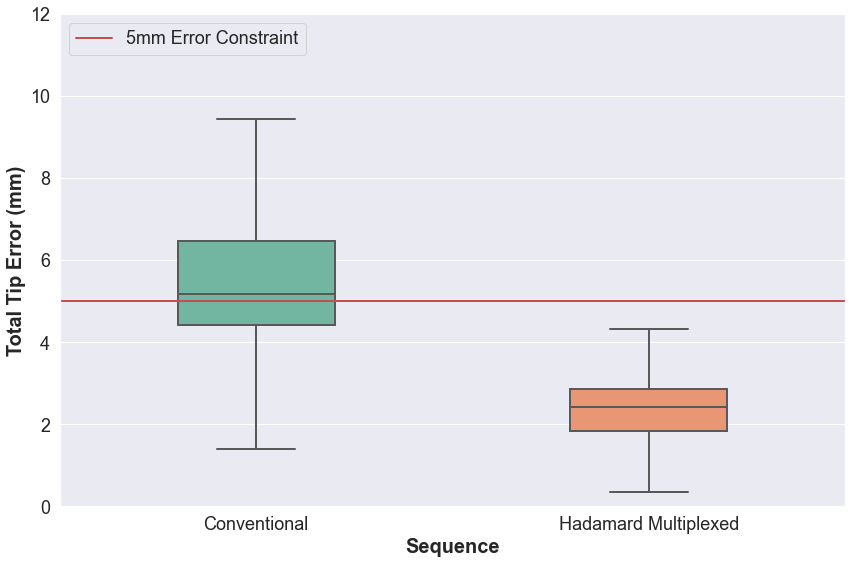

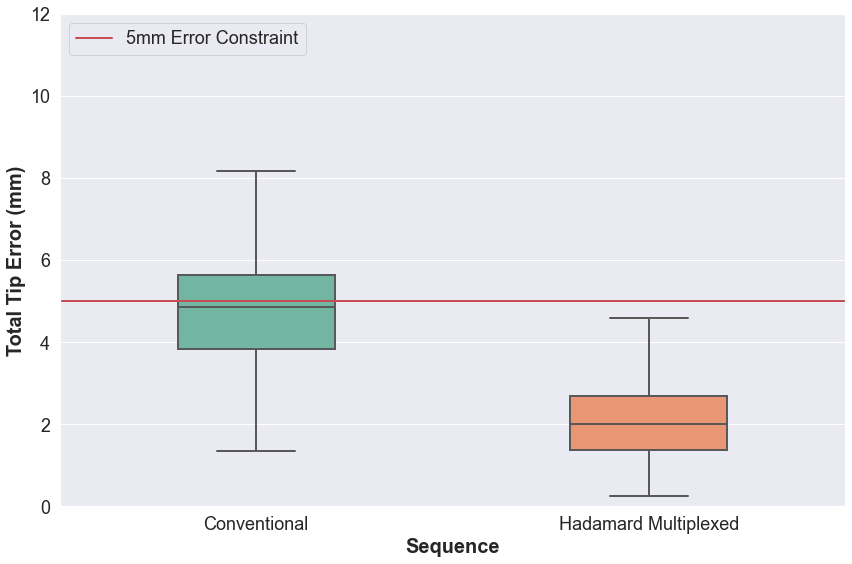

In [174]:
# Merge data for error boxplots, plot them, and save them to directory

plot_df_resp = merge_plot_dfs([SRI_2_plot_df_231_resp, SRI_2_plot_df_299_resp, SRI_2_plot_df_306_resp, FH512_2_plot_df_231_resp, FH512_2_plot_df_299_resp, FH512_2_plot_df_306_resp])
plot_df_card = merge_plot_dfs([SRI_2_plot_df_231_card, SRI_2_plot_df_299_card, SRI_2_plot_df_306_card, FH512_2_plot_df_231_card, FH512_2_plot_df_299_card, FH512_2_plot_df_306_card])

plot_error_box_plot(plot_df_resp, box_plot_path)
plot_error_box_plot(plot_df_card, box_plot_path)